# (not yet fully amortised) Inference on Moran model

In [1]:
import delfi.distribution as dd
import delfi.generator as dg
import delfi.inference as infer
import delfi.utils.io as io
import delfi.summarystats as ds
import lfimodels.moran.utils as utils
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pickle

from lfimodels.moran.Moran import Moran
from lfimodels.moran.MoranStats import MoranStats
from delfi.utils.viz import plot_pdf
from matplotlib.backends.backend_pdf import PdfPages

%matplotlib inline

## model, prior, summary statistics, generator

In [2]:
seed = 1
n_summary = 6
pre_computed = 0


# define model, prior, summary statistics and generator
n_processes = 10

if n_processes>1:
    seeds_model = np.arange(1,n_processes+1,1)
    m = []
    for i in range(n_processes):
        m.append(Moran(seed=seeds_model[i]))
    p = utils.prior(seed=seed)
    s = MoranStats(n_summary=n_summary)
    g = dg.MPGenerator(models=m, prior=p, summary=s)
else:
    seed = None
    m = Moran(seed=seed)
    p = utils.prior(seed=seed)
    s = MoranStats(n_summary=n_summary)
    g = dg.Default(model=m, prior=p, summary=s)

## pilot run for amortisation (run once and then comment out)

In [3]:
# # different recordings
# rec_WT = ['WT', 'WT.1', 'WT.3', 'WT.4', 'WT.5', 'WT.6',  'WT.8']

# rec = rec_WT[0]
# obs = utils.LTP_obs_data(rec=rec)
# obs_stats = utils.LTP_obs_stats(rec=rec)

In [4]:
# # hyperparameters for pilot run and inference
# seed_inf = 1

# pilot_samples = 1000000

# # network setup
# n_hiddens = [50,50]

# # convenience
# prior_norm = True

# # MAF parameters
# density = 'maf'
# n_mades = 5         # number of MADES

In [5]:
# # inference object
# res = infer.APT(g,
#                 obs=obs_stats,
#                 n_hiddens=n_hiddens,
#                 seed=seed_inf,
#                 pilot_samples=pilot_samples,
#                 n_mades=n_mades,
#                 prior_norm=prior_norm,
#                 density=density)

In [6]:
# # save pilot run
# filename = './results/pilot_run_amortisation_res.pkl'
# io.save(res, filename)

## load pilot run

In [7]:
filename = './results/pilot_run_amortisation_res.pkl'
res = io.load(filename)

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


## observed data

In [8]:
# different recordings
# rec_WT = ['WT', 'WT.1', 'WT.3', 'WT.4', 'WT.5', 'WT.6',  'WT.8']
# rec_Ts = ['Ts65Dn', 'Ts65Dn.1', 'Ts65Dn.3', 'Ts65Dn.4', 'Ts65Dn.5','Ts65Dn.6', 'Ts65Dn.8']
rec_WT = ['WT_slice-'+str(i+1) for i in range(14)]
rec_Ts = ['Ts65Dn_slice-'+str(i+1) for i in range(14)]
rec_Ts_Bume = ['BUME_slice-'+str(i+1) for i in range(17)]
rec_Ts_DMSO = ['DMSO_slice-'+str(i+1) for i in range(19)]


condition = 'dmso'

if condition=='wt':
    rec = rec_WT[13]
    obs = utils.LTP_obs_data(rec=rec)
    obs_stats = utils.LTP_obs_stats(rec=rec)
elif condition=='ts':
    rec = rec_Ts[13]
    obs = utils.LTP_obs_data(rec=rec)
    obs_stats = utils.LTP_obs_stats(rec=rec)
elif condition=='bume':
    rec = rec_Ts_Bume[16]
    obs = utils.LTP_obs_data(rec=rec)
    obs_stats = utils.LTP_obs_stats(rec=rec)
elif condition=='dmso':
    rec = rec_Ts_DMSO[18]
    obs = utils.LTP_obs_data(rec=rec)
    obs_stats = utils.LTP_obs_stats(rec=rec)

In [9]:
np.shape(obs['data'])

(200,)

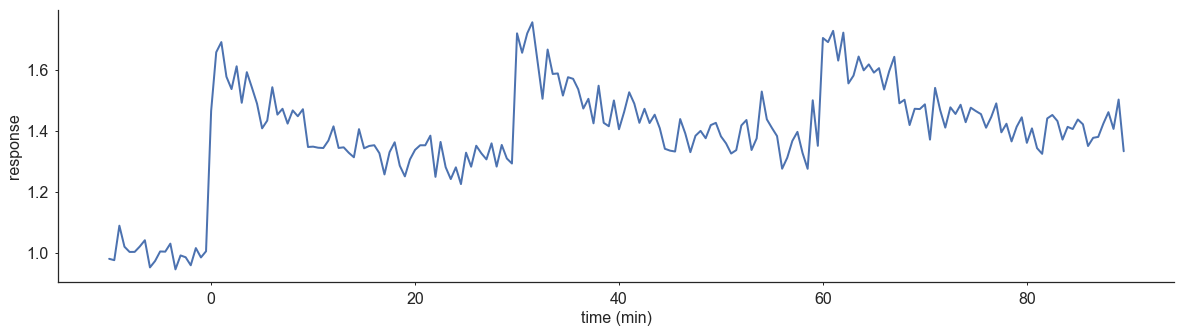

In [10]:
# mpl.rc('axes',edgecolor='k')
plt.figure(figsize=(20,5))

t = obs['time']
N = obs['data'].shape[0]

plt.plot(t, obs['data'], lw=2)
plt.xlabel('time (min)')
plt.ylabel('response');

In [11]:
obs_stats

array([[1.69174671, 1.75674302, 1.72858353, 1.31251537, 1.37714555,
        1.40517385]])

## update res with desired x_o

In [12]:
# old x_o
print(res.obs)

# new x_o
res.obs = obs_stats

print(res.obs)

[[2.40393793 2.7530727  3.1546277  1.73223038 2.03776192 2.21389588]]
[[1.69174671 1.75674302 1.72858353 1.31251537 1.37714555 1.40517385]]


# Inference using SNPE with one round

In [13]:
# inference hyperparameters

# training schedule
n_train = 1000000
n_rounds = 1

# fitting setup
minibatch = 100
epochs = 100
val_frac = 0.05

In [14]:
# train
log, train_data, posterior = res.run(
                    n_train=n_train,
                    n_rounds=n_rounds,
                    minibatch=minibatch,
                    epochs=epochs,
                    silent_fail=False,
                    proposal='prior',
                    val_frac=val_frac,
                    verbose=True,)

HBox(children=(IntProgress(value=0, max=100000000), HTML(value='')))

0/|/Training on 950000 samples:   0%|| 0/100000000 [00:00<?, ?it/s]Stopping at epoch 21.0, training loss = 0.2863318033659351, validation loss = 0.538891455466215




## save results

In [15]:
filename = './results/posterior_single_round_{rec}.pkl'.format(rec=rec)
io.save_pkl((log, train_data, posterior), filename)

In [16]:
n_summary = 6

0.968765
0.959244
0.957443
0.970504
0.965629
0.963365


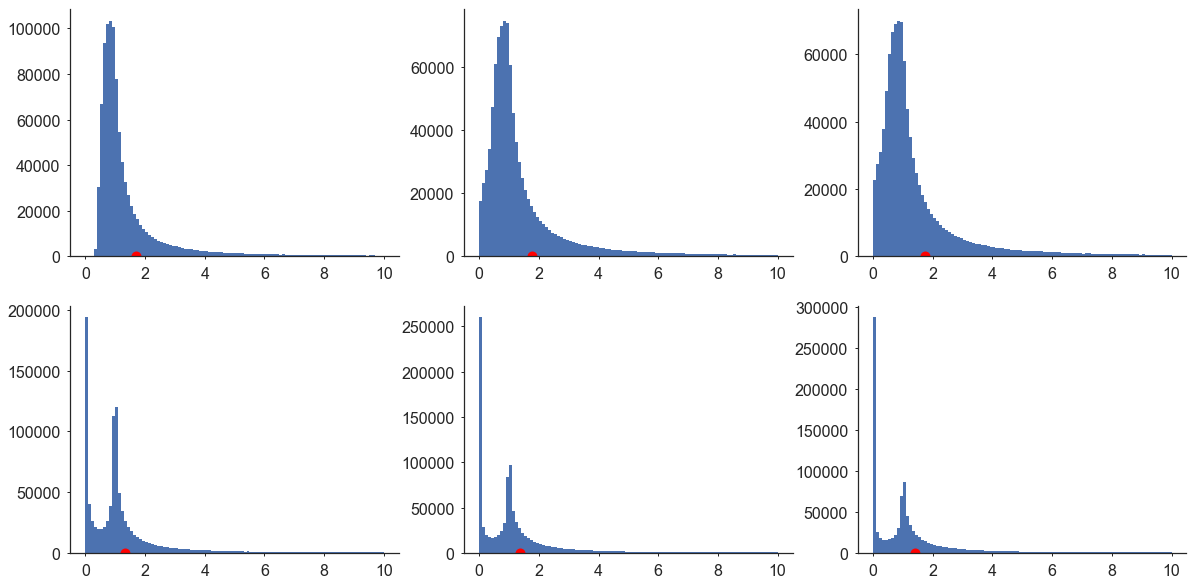

In [17]:
fig = plt.figure(figsize=(20,10))
for i in range(n_summary):
    a = len(train_data[0][1][:,i]*res.stats_std[i]+res.stats_mean[i])
    b = np.sum(train_data[0][1][:,i]*res.stats_std[i]+res.stats_mean[i]<10)
    print(b/a)
    plt.subplot(2,3,i+1)
    plt.hist(train_data[0][1][:,i]*res.stats_std[i]+res.stats_mean[i],bins=100,range=(0, 10))
    plt.plot(obs_stats[0,i],1,'or',markersize=10, label='obs stat')

## Analyse results

### Loss function

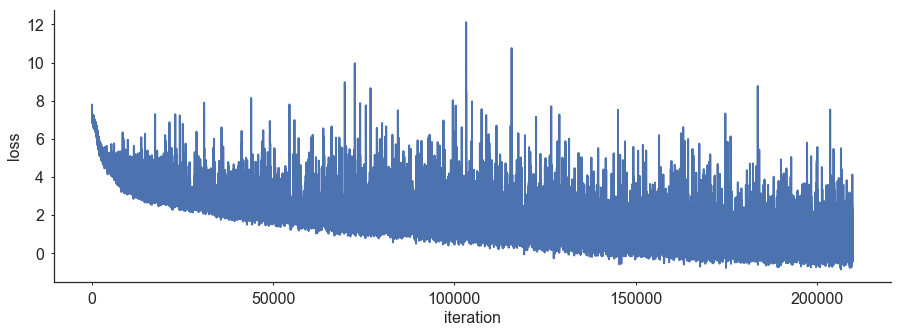

In [18]:
fig = plt.figure(figsize=(15,5))

plt.plot(log[0]['loss'],lw=2)
plt.xlabel('iteration')
plt.ylabel('loss');

## Posterior distribution

In [19]:
###################
# colors
hex2rgb = lambda h: tuple(int(h[i:i+2], 16) for i in (0, 2, 4))

# RGB colors in [0, 255]
col = {}
col['GT']      = hex2rgb('30C05D')
col['SNPE']    = hex2rgb('2E7FE8')
col['SAMPLE1'] = hex2rgb('8D62BC')
col['SAMPLE2'] = hex2rgb('AF99EF')

# convert to RGB colors in [0, 1]
for k, v in col.items():
    col[k] = tuple([i/255 for i in v])

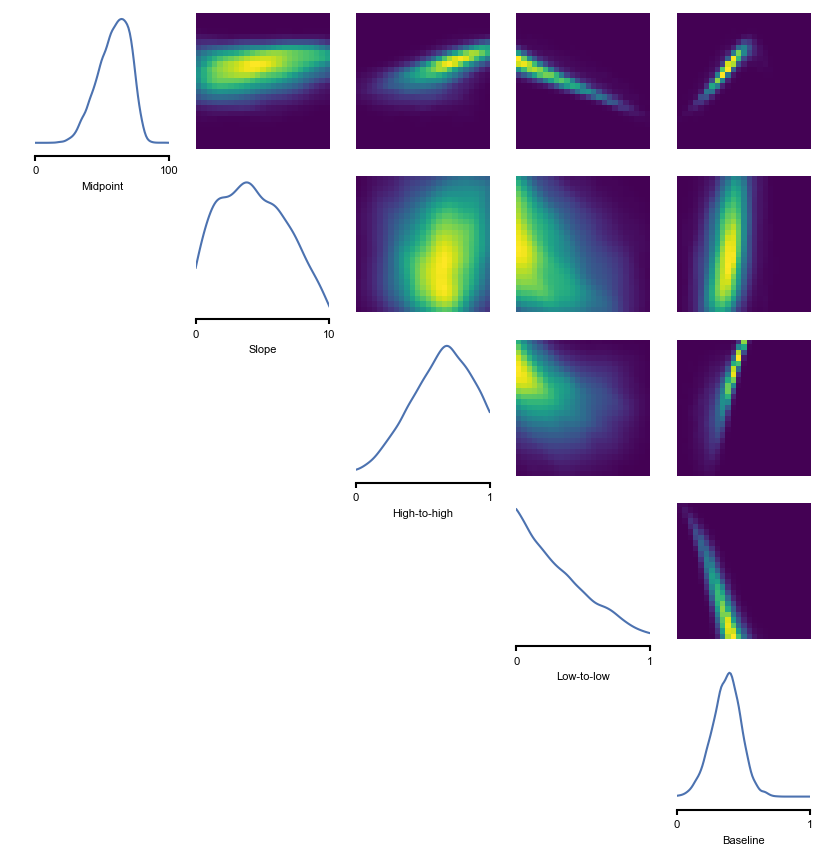

In [20]:
from delfi.utils.viz import samples_nd

prior_min = g.prior.lower
prior_max = g.prior.upper
prior_lims = np.concatenate((prior_min.reshape(-1,1),prior_max.reshape(-1,1)),axis=1)

labels_params = ['Midpoint', 'Slope', 'High-to-high', 'Low-to-low', 'Baseline']

posterior_samples = posterior[0].gen(10000)

# with PdfPages('Moran_posterior_'+rec+'.pdf') as pdf:
fig, axes = samples_nd(posterior_samples,
                       limits=prior_lims,
                       ticks=prior_lims,
                       labels=labels_params,
                       fig_size=(10,10),
                       scatter_offdiag={'rasterized':True, 'alpha':1.0},
                       diag=['kde', 'None'],
                       upper=['kde', 'plot'],
                       hist_offdiag={'bins': 50},
                       points_offdiag={'markersize': 5},
                       title='');
# #     plt.show()
#     pdf.savefig()
#     plt.close()

## Observed data and samples from posterior

In [21]:
# sample from posterior
n_snpe_all = 100000
num_samp = 50000

samples_snpe_all = posterior[-1].gen(n_snpe_all)
ind_hi_prob_snpe = np.argsort(posterior[-1].eval(samples_snpe_all),axis=0)[::-1]
x_samp = samples_snpe_all[ind_hi_prob_snpe[0:num_samp],:]
# x_samp = posterior[0].gen(n_samples=num_samp)

# reject samples for which prior is zero
ind = (x_samp > prior_min) & (x_samp < prior_max)
params = x_samp[np.prod(ind,axis=1)==1]

num_samp = len(params[:,0])

In [22]:
np.shape(params)

(29610, 5)

In [ ]:
from lfimodels.moran.moranFunctions_v3 import run_sequential_ltp

fig = plt.figure(figsize=(10,5))

y_obs = obs['data']
t = obs['time']

# simulate and plot samples
stats_samples = np.zeros((n_summary,num_samp))
response_ls = []
for i in range(num_samp):
    
    # parameters not fitted. Some with variability
    num_synapse = np.random.randint(900,1100)
    num_receptors = np.random.randint(90,110)
    param_fixed = [100, num_synapse, num_receptors, 1.0] #time_plast, num_synapse, num_receptors, gifit
    
    # numerical simulation
    simulation  = run_sequential_ltp(param_fixed, list(params[i,:]))
    response = simulation['wholetraj']/simulation['wholetraj'][0]
    stats_samples[:,i] = np.asarray(simulation['responseStrength'])
    response_ls.append(response)
    
#     # analytical simulation
#     x = m[0].gen_single(params[i,:])
#     stats_samples[:,i] = s.calc([x])
    
    # plot numerical simulations
    t_sim = np.linspace(t[0],t[-1],len(response))
    plt.plot(t_sim,response)

    if i==num_samp-1:
        # plot observation
        plt.plot(t, y_obs, color=col['GT'])
        plt.xlabel('time (min)')
        plt.ylabel('response')

ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.3, 1), loc='upper right');

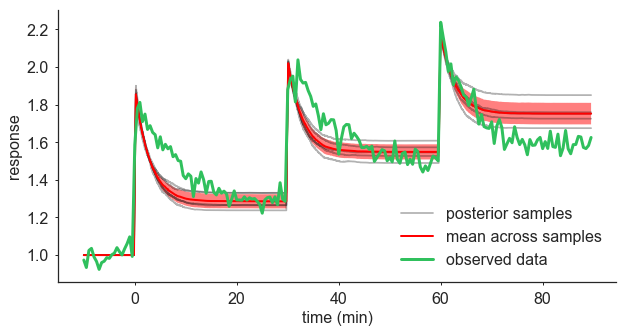

In [29]:
response_mat = np.asarray(response_ls).T
mn_response = np.mean(response_mat,1)
std_response = np.std(response_mat,1)

# with PdfPages('Moran_samples_'+rec+'.pdf') as pdf:
fig = plt.figure(figsize=(10,5))
plt.plot(t_sim,response_mat[:,:-1],'k', alpha=0.3)
plt.plot(t_sim,response_mat[:,-1],'k', alpha=0.3, label='posterior samples')
plt.plot(t_sim,mn_response,'r',lw=2, label='mean across samples')
ax = plt.gca()
ax.fill_between(t_sim,
                mn_response-std_response,
                mn_response+std_response,
                facecolor='r', alpha=0.5)
plt.plot(t,y_obs,color=col['GT'],lw=3, label='observed data')
plt.xlabel('time (min)')
plt.ylabel('response')
plt.legend();

# #     plt.show()
#     pdf.savefig()
#     plt.close()

## summary statistics

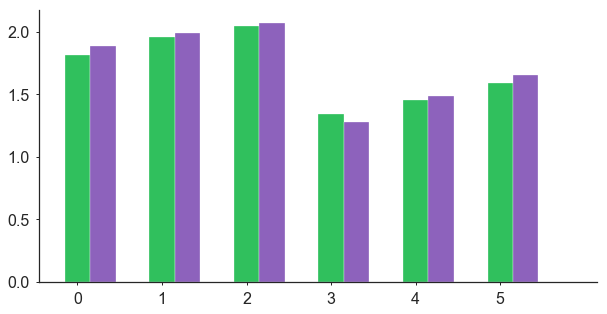

In [29]:
fig = plt.figure(figsize=(10,5))
width = 0.3
plt.bar(np.linspace(0,n_summary-1,n_summary),obs_stats[0],
        width=width,color=col['GT'], edgecolor='w', label='observation')
plt.bar(np.linspace(0,n_summary-1,n_summary)+width,
        stats_samples[:,0]/simulation['wholetraj'][0],color=col['SAMPLE1'],
        width=width, edgecolor='w', label='SNPE')
ax = plt.gca()
ax.set_xlim(-1.5*width,n_summary+width/2)
ax.set_xticks(np.linspace(0,n_summary-1,n_summary))

# plt.yscale('log')
plt.show()

In [28]:
obs_stats[0]

array([2.43157007, 2.93103187, 3.18933752, 1.7534573 , 2.2168645 ,
       2.45242607])

In [29]:
stats_samples[:,0]/simulation['wholetraj'][0]

array([2.48942673, 3.01721766, 3.39665948, 1.88664515, 2.52773816,
       2.98566174])